In [1]:
push!(LOAD_PATH, "/Users/jayyao/Documents/Research/PINN/NewGridap/Module")
using PINN
using Gridap
using GridapGmsh
using Gridap.Geometry
using NLopt
using LinearAlgebra
# Geometry parameters of the mesh
L = 4.0           # Length of the normal region
h1 = 3.0          # Height of the upper region
h2 = 1.5          # Height of the lower region above source
h3 = 1.5          # Height of the lower region below source
dpml = 1.0        # Thickness of the PML
hd = 1.0          # Height of the design region

LHp=[L/2 h1]
LHn=[L/2 hd+h2+h3]

# Characteristic length (controls the resolution, smaller the finer)
λ = 1.0           # Wavelength (aribitrary unit)
resol = 15.0      # Number of points per wavelength
l0 = λ/resol      # Normal region
ld = l0/2.0       # Design region
lpml = 2*l0       # PML 


# Physical parameters 
k = 2*π/λ        # Wave number 
ω = k            # c=1
ϵ1 = 1.0         # Relative electric permittivity for material 1
ϵ2 = 12.0        # Relative electric permittivity for material 2
μ = 1.0          # Relative magnetic permeability for all materials

# PML parameters
R = 1e-4         # Tolerence for PML reflection 
σ1 = -3/4*log(R)/dpml/√ϵ1
σ2 = -3/4*log(R)/dpml/√ϵ2
σs = [σ1 σ2]

################## Generate mesh and create model
MeshGenerator(L,h1,h2,h3,hd,dpml,l0,ld,lpml)

############## Gridap Setup ##################
model = GmshDiscreteModel("geometry.msh")

order = 1
diritags = ["BottomEdge","TopEdge", "BottomNodes", "TopNodes"]
neumanntags = ["LeftEdge","RightEdge","LeftNodes","RightNodes","LeftDEdge","RightDEdge","LeftDNodes","RightDNodes"]
sourcetags = ["SourceNodes","SourceEdge"]
designboundarytags = ["LeftDEdge","RightDEdge","TBDEdge","TBDNodes","LeftDNodes","RightDNodes"]
# Test and trial finite element function space
# Scalar-valued shape functions,
# but a complex vector of free DOFs to represent the solution.
# (this automatically leads to complex sparse matrices when assembling)
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,dirichlet_tags=diritags,vector_type=Vector{ComplexF64})
U = TrialFESpace(V,[0 0 0 0])

# Piece-wise constant parameter FE function space
p_reffe = ReferenceFE(lagrangian,Float64,0)
Q = TestFESpace(model,p_reffe,vector_type=Vector{Float64})
P = TrialFESpace(Q)

# Filtered parameter FE function space
pf_reffe = ReferenceFE(lagrangian,Float64,order)
Qf = TestFESpace(model,pf_reffe,vector_type=Vector{Float64})
Pf = TrialFESpace(Qf)

############### Integration domain ################
degree = 2
Ω = Triangulation(model)
dΩ = Measure(Ω,degree)


############### Get the sub-region ################
labels = get_face_labeling(model)
dimension = num_cell_dims(model)
tags = get_face_tag(labels,dimension)
const design_tag = get_tag_from_name(labels,"Design")
cellmask_d = get_face_mask(labels,"Design",dimension)
const target_tag = get_tag_from_name(labels,"Target")
cellmask_t = get_face_mask(labels,"Target",dimension)
Ω_d = Triangulation(model,cellmask_d)
dΩ_d = Measure(Ω_d,degree)
Ω_t = Triangulation(model,cellmask_t)
dΩ_t = Measure(Ω_t,degree)
# Number of cells in design region (number of design parameters)
np = num_cells(Ω_d)

Γ = BoundaryTriangulation(model;tags=neumanntags)
dΓ = Measure(Γ,degree)

Γ_d = BoundaryTriangulation(model;tags=designboundarytags)
dΓ_d = Measure(Γ_d,degree)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve 22 (Line)
Info    : Meshing curve 23 (Line)
Info    : Meshing curve 24 (Line)
Info    : Meshing curve 25 (Line)
Info    : Meshing curve 26 (Line)
Info    : Mes

Measure()

In [31]:
############  Optimization parameters #############
# Source (particle) locations
x0 = [0 -h2-hd]
δ = [L 0.2]

# Target locations


flag_f = true
flag_t = false

# Filter and threshold paramters
r = ld*2.0       # Filter radius
β = 1.0          # β∈[1,∞], threshold sharpness
η = 0.5          # η∈[0,1], threshold center


Amp = 1.0
Lt = 1.0
Ht = 1.0

opt = Opt(:LD_MMA, np)
opt.lower_bounds = 0.0
opt.upper_bounds = 1.0
opt.ftol_rel = 1e-6
#opt.stopval = 0.0505*L*h1
opt.maxeval = 500
opt.min_objective = (p,grad)->g_p(p,grad;x0,δ,Amp,r,flag_f,P,Pf,Qf,β,η,flag_t,
        ϵ1,ϵ2,μ,σs,k,LHp,LHn,dpml,hd,h1,Lt,Ht,U,V,dΩ,dΓ,dΩ_t,dΓ_d,tags,design_tag)

(g_opt,p_opt,ret) = optimize(opt, zeros(np))
#(g_opt,p_opt,ret) = optimize(opt, p)
@show numevals = opt.numevals # the number of function evaluations

p_min = p_opt
pvec = p_vec(p_min,P,tags,design_tag)
pf = Filter(pvec,r,flag_f,P,Pf,Qf,dΩ,dΓ_d)
if (flag_f)
    pfh = FEFunction(Pf,pf)
else
    pfh = FEFunction(P,pf)
end
ph = (pf->Threshold(β,η,flag_t,pf))∘pfh
A_mat = MatrixA(ph,ϵ1,ϵ2,μ,σs,k,LHp,LHn,dpml,hd,U,V,dΩ)
B_vec = MatrixB(x0,δ,2*π*Amp,V,dΩ,dΓ)

u_vec = A_mat\B_vec

uh=FEFunction(U,u_vec)
writevtk(Ω,"demo",cellfields=[
  "ϵ0"=>(ϵ1+(ϵ2-ϵ1)*FEFunction(P,p_vec(p_min,P,tags,design_tag))),
  "ϵf"=>(ϵ1+(ϵ2-ϵ1)*pfh),
  "ϵt"=>(ϵ1+(ϵ2-ϵ1)*((pf->Threshold(β,η,flag_t,pf))∘pfh)),
  "Real"=>real(uh),
  "Imag"=>imag(uh),
  "|E|^2"=>abs2(uh)])
g_u(u_vec;Amp,h1,Lt,Ht,U,V,dΩ_t)/h1/L

g_value = 0.9288483443099802
g_value = 0.9279919412543947
g_value = 0.9196902411984622
g_value = 0.8466423801053614
g_value = 0.8706329201131077
g_value = 0.7671978422118725
g_value = 0.7233180256717265
g_value = 0.7211962094993143
g_value = 0.6952532709540373
g_value = 0.691675911961142
g_value = 0.6832216046052562
g_value = 0.9880736281080521
g_value = 0.8239498272078181
g_value = 0.6786832872160684
g_value = 0.6765787576294222
g_value = 0.6747942189927095
g_value = 0.6736026305784895
g_value = 0.7949277412533212
g_value = 0.6637701039338796
g_value = 0.6601628905969019
g_value = 0.7208323072206497
g_value = 0.6550576201725213
g_value = 0.6538703310812842
g_value = 0.6513540847400688
g_value = 0.7218768936084218
g_value = 0.6486193910827676
g_value = 0.6653074637350561
g_value = 0.6476140332717832
g_value = 0.727340217942363
g_value = 0.6472183585264348
g_value = 0.6465931598274892
g_value = 0.6461943224814826
g_value = 0.6445672973940019
g_value = 1.0074572788160354
g_value = 0.7010

g_value = 0.6366605910686802
g_value = 0.634957789509715
g_value = 0.6351006185530316
g_value = 0.6349466998435047
g_value = 0.6355616441036892
g_value = 0.6349369413345806
g_value = 0.6354317613218023
g_value = 0.6349242018885187
g_value = 0.6354860314714531
g_value = 0.6349086585454344
g_value = 0.6354900889799435
g_value = 0.6348915556612884
g_value = 0.6353689903613557
g_value = 0.6348729474006279
g_value = 0.6348770039781514
g_value = 0.6348619676063555
g_value = 0.634929753671604
g_value = 0.6348484751833169
g_value = 0.6348965880806227
g_value = 0.6348378665823228
g_value = 0.6347955527166208
g_value = 0.7239595728177581
g_value = 0.6356775190546738
g_value = 0.634785114235517
g_value = 0.6347786294281236
g_value = 0.6347476893715308
g_value = 0.6354582764305292
g_value = 0.6347174463118934
g_value = 0.6347091145932455
g_value = 0.6358909780609088
g_value = 0.6346444421137941
g_value = 0.634748918258598
g_value = 0.6346310156434066
g_value = 0.6373334722798324
g_value = 0.634628

0.05272883576995415

In [29]:
using Gridap.Visualization
using Gridap.Geometry
using Gridap.ReferenceFEs
results = visualization_data(Ω,"demo",cellfields=[
  "ϵ0"=>(ϵ1+(ϵ2-ϵ1)*FEFunction(P,p_vec(p_min,P,tags,design_tag))),
  "ϵf"=>(ϵ1+(ϵ2-ϵ1)*pfh),
  "ϵt"=>(ϵ1+(ϵ2-ϵ1)*((pf->Threshold(β,η,flag_t,pf))∘pfh)),
  "Real"=>real(uh),
  "Imag"=>imag(uh),
  "|E|^2"=>abs2(uh)])
#propertynames(results[1])
vd = results[1]
node_coords = get_node_coordinates(vd.grid)
cell_node_ids = get_cell_node_ids(vd.grid)
ϵ_val = vd.nodaldata["ϵt"]
Esqua_val = vd.nodaldata["|E|^2"]
N_nodes = length(node_coords)
coord_x=zeros(N_nodes)
coord_y=zeros(N_nodes)
for i=1:N_nodes
    coord_x[i] = node_coords[i][1]
    coord_y[i] = node_coords[i][2]
end

open("epsilon.txt", "w") do f
    for i=1:N_nodes
        xi=coord_x[i]
        yi=coord_y[i]
        ϵi=ϵ_val[i]
        write(f, "$xi $yi $ϵi","\n")
    end
end

open("Esquare.txt", "w") do f
    for i=1:N_nodes
        xi=coord_x[i]
        yi=coord_y[i]
        Esquare=Esqua_val[i]
        write(f, "$xi $yi $Esquare","\n")
    end
end

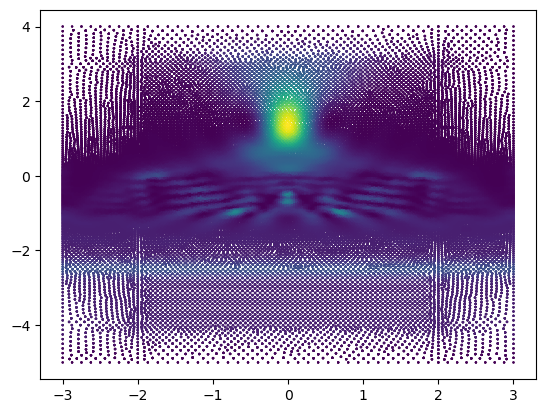

PyObject <matplotlib.collections.PathCollection object at 0x7fb2140e4510>

In [27]:
#using PyPlot
#scatter(coord_x,coord_y,c=Esqua_val,s=0.5)

In [ ]:
using Richardson

using Random
p0 = rand(np)
δp = rand(np)
extrapolate(δp*0.1, rtol=0) do h
    @show norm(h)
    (g_p(p0+h;x0,δ,Amp,r,flag_f,P,Pf,Qf,β,η,flag_t,
        ϵ1,ϵ2,μ,σs,k,LHp,LHn,dpml,hd,h1,Lt,Ht,U,V,dΩ,dΓ,dΩ_t,dΓ_d,tags,design_tag)-
     g_p(p0;x0,δ,Amp,r,flag_f,P,Pf,Qf,β,η,flag_t,
        ϵ1,ϵ2,μ,σs,k,LHp,LHn,dpml,hd,h1,Lt,Ht,U,V,dΩ,dΓ,dΩ_t,dΓ_d,tags,design_tag)) / norm(h)
end

In [ ]:
grad = zeros(np)
g_p(p0,grad;x0,δ,Amp,r,flag_f,P,Pf,Qf,β,η,flag_t,
        ϵ1,ϵ2,μ,σs,k,LHp,LHn,dpml,hd,h1,Lt,Ht,U,V,dΩ,dΓ,dΩ_t,dΓ_d,tags,design_tag)
grad'*δp/norm(δp)


In [ ]:
pf, pf_pullback = rrule(pf_p,p0;r,flag_f,P,Pf,Qf,dΩ,dΓ_d,tags,design_tag)
u_vec, u_pullback = rrule(u_pf,pf;x0,δ,Amp,P,Pf,β,η,flag_t,ϵ1,ϵ2,μ,σs,k,LHp,LHn,dpml,hd,U,V,dΩ,dΓ)
g, g_pullback = rrule(g_u,u_vec;Amp,h1,Lt,Ht,U,V,dΩ_t)
dgdg = 1
_, dgdu = g_pullback(dgdg)
_, dgdpf = u_pullback(dgdu)
_, dgdp = pf_pullback(dgdpf)

dgdp'*δp/norm(δp)

In [4]:
g_u(u_vec;Amp,h1,Lt,Ht,U,V,dΩ_t)/h1/L

0.04979341235618561